# Part 3
In this part, you will analyze and experiment with a modification of Dijkstra’s algorithm called the A*
(we will cover this algorithm in next lecture, but you are free to do your own research if you want to get
started on it). The algorithm essentially, is an “informed” search algorithm or “best-first search”, and is
helpful to find best path between two given nodes. Best path can be defined by shortest path, best time, or
least cost. The most important feature of A* is a heuristic function that can control it’s behavior.


Part 3.1: Write a function A_Star (graph, source, destination, heuristic) which takes in a directed weighted
graph, a sources node, a destination node , and a heuristic “function”. Assume h is a dictionary which
takes in a node (an integer), and returns a float. Your method should return a 2-tuple where the first
element is a predecessor dictionary, and the second element is the shortest path the algorithm determines
from source to destination. This implementation should be using priority queue.

In [43]:
import math
import random
import time
import timeit 
import matplotlib.pyplot as plt
import numpy as np

In [45]:
#weighted digraph
class DWG:

    def __init__(self):
        self.adj = {}
        self.weights = {}

    def are_connected(self, node1, node2):
        for neighbour in self.adj[node1]:
            if neighbour == node2:
                return True
        return False

    def adjacent_nodes(self, node):
        return self.adj[node]

    def add_node(self, node):
        self.adj[node] = []

    def add_edge(self, node1, node2, weight):
        if node2 not in self.adj[node1]:
            self.adj[node1].append(node2)
        self.weights[(node1, node2)] = weight

    def w(self, node1, node2):
        if self.are_connected(node1, node2):
            return self.weights[(node1, node2)]
    def to_dict(self):
        """
        Convert the graph into a dictionary of dictionaries format.

        Returns:
        - graph_dict: A dictionary representing the graph.
        """
        graph_dict = {}
        for node, neighbors in self.adj.items():
            neighbors_dict = {}
            for neighbor in neighbors:
                weight = self.w(node, neighbor)
                if weight is not None:
                    neighbors_dict[neighbor] = weight
            graph_dict[node] = neighbors_dict
        return graph_dict
    def num_nodes(self):
        return len(self.adj)
    def heuristic(self, node, destination):
        if node in self.adj.keys():
            if destination in self.adj[node]:
                return self.w(node, destination)
            else:
                total_weight = 0
                edge_count = 0
                for neighbors in self.adj[node]:
                        edge_weight = self.w(node, neighbors)
                        total_weight += edge_weight
                        edge_count += 1
                if edge_count == 0:
                    return 0  # Return 0 if there are no edges
                return total_weight / edge_count
    def __str__(self):
        result = ""
        for node, neighbors in self.adj.items():
            result += f"Node {node}: "
            if neighbors:
                for neighbor in neighbors:
                    weight = self.weights.get((node, neighbor), "N/A")
                    result += f"{neighbor} (Weight: {weight}), "
                result = result[:-2]  # Remove the last comma and space
            else:
                result += "No outgoing edges"
            result += "\n"
        return result

In [46]:
class Item:
    def __init__(self, value, key):
        self.key = key
        self.value = value
    
    def __str__(self):
        return "(" + str(self.key) + "," + str(self.value) + ")"
class MinHeap:
    def __init__(self, data):
        self.items = data
        self.length = len(data)
        self.build_heap()

        # add a map based on input node
        self.map = {}
        for i in range(self.length):
            self.map[self.items[i].value] = i

    def find_left_index(self,index):
        return 2 * (index + 1) - 1

    def find_right_index(self,index):
        return 2 * (index + 1)

    def find_parent_index(self,index):
        return (index + 1) // 2 - 1  
    
    def sink_down(self, index):
        smallest_known_index = index

        if self.find_left_index(index) < self.length and self.items[self.find_left_index(index)].key < self.items[index].key:
            smallest_known_index = self.find_left_index(index)

        if self.find_right_index(index) < self.length and self.items[self.find_right_index(index)].key < self.items[smallest_known_index].key:
            smallest_known_index = self.find_right_index(index)

        if smallest_known_index != index:
            self.items[index], self.items[smallest_known_index] = self.items[smallest_known_index], self.items[index]
            
            # update map
            self.map[self.items[index].value] = index
            self.map[self.items[smallest_known_index].value] = smallest_known_index

            # recursive call
            self.sink_down(smallest_known_index)

    def build_heap(self,):
        for i in range(self.length // 2 - 1, -1, -1):
            self.sink_down(i) 

    def insert(self, node):
        if len(self.items) == self.length:
            self.items.append(node)
        else:
            self.items[self.length] = node
        self.map[node.value] = self.length
        self.length += 1
        self.swim_up(self.length - 1)

    def insert_nodes(self, node_list):
        for node in node_list:
            self.insert(node)

    def swim_up(self, index):
        
        while index > 0 and self.items[self.find_parent_index(index)].key < self.items[self.find_parent_index(index)].key:
            #swap values
            self.items[index], self.items[self.find_parent_index(index)] = self.items[self.find_parent_index(index)], self.items[index]
            #update map
            self.map[self.items[index].value] = index
            self.map[self.items[self.find_parent_index(index)].value] = self.find_parent_index(index)
            index = self.find_parent_index(index)

    def get_min(self):
        if len(self.items) > 0:
            return self.items[0]

    def extract_min(self,):
        #xchange
        self.items[0], self.items[self.length - 1] = self.items[self.length - 1], self.items[0]
        #update map
        self.map[self.items[self.length - 1].value] = self.length - 1
        self.map[self.items[0].value] = 0

        min_node = self.items[self.length - 1]
        self.length -= 1
        self.map.pop(min_node.value)
        self.sink_down(0)
        return min_node

    def decrease_key(self, value, new_key):
        if new_key >= self.items[self.map[value]].key:
            return
        index = self.map[value]
        self.items[index].key = new_key
        self.swim_up(index)

    def get_element_from_value(self, value):
        return self.items[self.map[value]]
    
    def __contains__(self, value):
        for item in self.items:
            if item.value == value:
                return True
        return False

    def is_empty(self):
        return self.length == 0
    
    def __str__(self):
        height = math.ceil(math.log(self.length + 1, 2))
        whitespace = 2 ** height + height
        s = ""
        for i in range(height):
            for j in range(2 ** i - 1, min(2 ** (i + 1) - 1, self.length)):
                s += " " * whitespace
                s += str(self.items[j]) + " "
            s += "\n"
            whitespace = whitespace // 2
        return s


In [47]:
import math
def A_star(graph, source, destination, h):
    
    openset = MinHeap([])
    openset.insert(Item(source, float('inf')))
    cameFrom = {}
    gscore = {node : float('inf') for node in graph.adj.keys()}
    gscore[source] = 0
    fscore = {node : float('inf') for node in graph.adj.keys()}
    fscore[source] = h[source]
    while not openset.is_empty():
        current_min = openset.extract_min()        
        if current_min == destination:
            break
        if current_min is None:
            break
        current = current_min.value
        for neighbour in graph.adj[current]:
            t_gscore = gscore[current]+ graph.w(current, neighbour)
            if t_gscore < gscore[neighbour]:
                cameFrom[neighbour] = current
                gscore[neighbour] = t_gscore
                fscore[neighbour] = t_gscore + h[neighbour]
                if neighbour not in openset:
                    openset.insert(Item(neighbour, fscore[neighbour]))
    shortestpath = []
    current = destination
    while current in cameFrom:
        shortestpath.insert(0, current)
        current = cameFrom[current]
    shortestpath.insert(0, source)
    return cameFrom, shortestpath
    

In [48]:
graph3 = DWG()
graph3.add_node(0)
graph3.add_node(1)
graph3.add_node(2)
graph3.add_node(3)
graph3.add_node(4)
graph3.add_node(5)
graph3.add_edge(0,1,1)
graph3.add_edge(0,2,4)
graph3.add_edge(1,2,2)
graph3.add_edge(1,3,5)
graph3.add_edge(2,3,1)
source = 0
destination = 2
h = {node : float(graph3.heuristic(node, destination)) for node in graph3.adj.keys()}
A_star(graph3, 0, 2, h)

({1: 0, 2: 1, 3: 2}, [0, 1, 2])

In [49]:
graph2 = DWG()
graph2.add_node(0)
graph2.add_node(1)
graph2.add_node(2)
graph2.add_node(3)
graph2.add_node(4)
graph2.add_node(5)
graph2.add_edge(0,1,1)
graph2.add_edge(0,2,4)
graph2.add_edge(1,2,2)
graph2.add_edge(1,3,5)
graph2.add_edge(2,3,1)
graph2.add_edge(3,5,1)
graph2.add_edge(0,5,2)
source = 0
destination = 5
h = {node : float(graph2.heuristic(node, destination)) for node in graph2.adj.keys()}
A_star(graph2, source, destination, h)

({1: 0, 2: 1, 5: 0, 3: 2}, [0, 5])

In [50]:
class MinHeap2:
    def __init__(self):
        self.heap = []

    def parent(self, i):
        return (i - 1) // 2

    def left_child(self, i):
        return 2 * i + 1

    def right_child(self, i):
        return 2 * i + 2

    def insert(self, val):
        self.heap.append(val)
        self._heapify_up(len(self.heap) - 1)

    def delete_min(self):
        if len(self.heap) == 0:
            return None  # Handle empty queue case

        self.heap[0], self.heap[-1] = self.heap[-1], self.heap[0]
        min_val = self.heap.pop()
        self._heapify_down(0)
        return min_val

    def _heapify_up(self, index):
        while index > 0 and self.heap[self.parent(index)] > self.heap[index]:
            self.heap[index], self.heap[self.parent(index)] = self.heap[self.parent(index)], self.heap[index]
            index = self.parent(index)

    def _heapify_down(self, index):
        while index < len(self.heap):
            smallest = index
            left = self.left_child(index)
            right = self.right_child(index)

            if left < len(self.heap) and self.heap[left] < self.heap[smallest]:
                smallest = left
            if right < len(self.heap) and self.heap[right] < self.heap[smallest]:
                smallest = right

            if smallest != index:
                self.heap[index], self.heap[smallest] = self.heap[smallest], self.heap[index]
                index = smallest
            else:
                break


    def put(self, node, priority):
        self.insert((priority, node))

    def is_empty(self):
        return len(self.heap) == 0

In [51]:

def dijkstra(graph, start, end):
    graph_dict = graph.to_dict()
    distance = {vertex: float('infinity') for vertex in graph_dict}
    distance[start] = 0
    predecessor = {vertex: None for vertex in graph_dict}
    pq = MinHeap2()
    pq.put(start, 0)
    
    while not pq.is_empty():
        _, current_node = pq.delete_min()  # Adjusted to work with the tuple (priority, node)
        
        if current_node == end:
            break

        for neighbor, weight in graph_dict[current_node].items():
            alt_route = distance[current_node] + weight
            if alt_route < distance[neighbor]:
                distance[neighbor] = alt_route
                predecessor[neighbor] = current_node
                pq.put(neighbor, alt_route)  # Use the adjusted put method
                
    # Reconstruct path from end to start using predecessors
    path = []
    current = end
    while current is not None:
        path.append(current)
        current = predecessor[current]
    path.reverse()  # Reverse the path to start from the beginning
    return distance[end], path


In [52]:
def generate_random_graph(num_nodes, num_edges, min_weight, max_weight):
    graph = DWG()
    
    # Add nodes
    for i in range(num_nodes):
        graph.add_node(i)
    
    # Add edges
    for _ in range(num_edges):
        node1 = random.randint(0, num_nodes - 1)
        node2 = random.randint(0, num_nodes - 1)
        
        # Ensure node1 and node2 are different
        while node1 == node2:
            node2 = random.randint(0, num_nodes - 1)
        
        weight = random.randint(min_weight, max_weight)
        graph.add_edge(node1, node2, weight)
    
    return graph

In [102]:
#making a sparse graph
graph1 = generate_random_graph(20, 10, 1, 5)


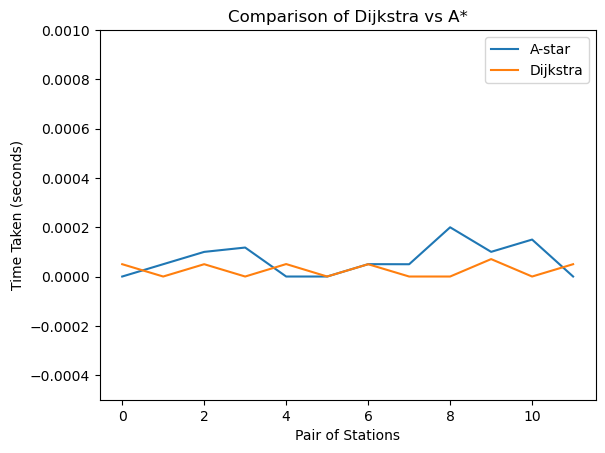

In [103]:
def compute_time_for_all_pairs(graph):
    dijkstra1 = []
    a_star = []
    for i in graph.adj.keys():
        for j in graph.adj.keys():
            if i !=j:
                dijkstra_times = []
                a_star_times = []
                for _ in range(20):# Avoid duplicate pairs
                    source = i
                    destination = j
                    #print(source, destination)
                    #getting the heuristic disctionary for euclidean distance
                    h = {node : graph.heuristic(node, destination) for node in graph.adj.keys()}
                    # Compute time taken by Dijkstra's algorithm
                    start_time = time.time()
                    dijkstra_length, _ = dijkstra(graph, source, destination)
                    end_time = time.time()
                    if dijkstra_length != float('infinity'): # Path exists
                        dijkstra_times.append(end_time-start_time)

                    # Compute time taken by A* algorithm

                    start_time = time.time()
                    _, a_star_path = A_star(graph, source, destination, h)
                    end_time = time.time()
                    if len(a_star_path)>1 and a_star_path is not None:
                        a_star_times.append(end_time-start_time)
                a_star.append(sum(a_star_times)/len(a_star_times)) if len(a_star_times) != 0 else 0
                dijkstra1.append(sum(dijkstra_times)/len(dijkstra_times)) if len(dijkstra_times) !=0 else 0
    return dijkstra1, a_star

# Plot a comparison graph
def plot_comparison_graph(dijkstra_times, a_star_times):
    plt.plot(a_star_times, label = "A-star")
    plt.plot(dijkstra_times, label='Dijkstra')
    plt.xlabel('Pair of Stations')
    plt.ylabel('Time Taken (seconds)')
    plt.title('Comparison of Dijkstra vs A*')
    plt.ylim(-0.0005, 0.0010)
    plt.legend()
    plt.show()

# Main code
dijkstra_times, a_star_times = compute_time_for_all_pairs(graph1)
plot_comparison_graph(dijkstra_times, a_star_times)


In [104]:
#normal graph
graph2 = generate_random_graph(20, 40, 1, 10)

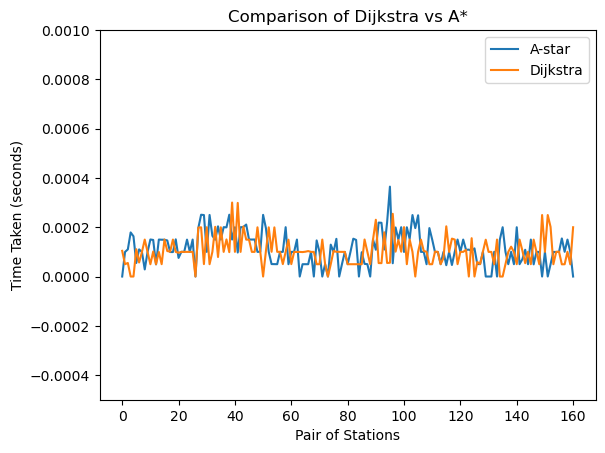

In [105]:
dijkstra_times, a_star_times = compute_time_for_all_pairs(graph2)
plot_comparison_graph(dijkstra_times, a_star_times)

In [106]:
#very dense graph
graph3 = generate_random_graph(20, 60, 1, 10)


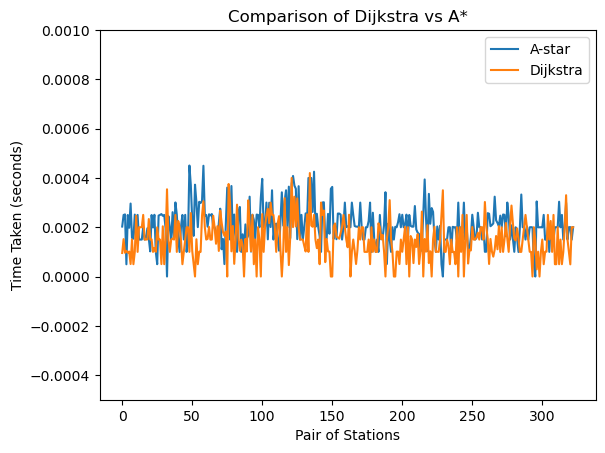

In [107]:
dijkstra_times, a_star_times = compute_time_for_all_pairs(graph3)
plot_comparison_graph(dijkstra_times, a_star_times)